# Loop 6 Analysis: Double Lattice Packing Investigation

The web search revealed that top teams use **dense 2-tree lattices with alternating up/down oriented trees** and **180° rotational symmetry**.

Let's analyze:
1. What patterns are in our current best solutions?
2. Are we using the optimal double-lattice pattern?
3. Where can we improve?

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# Tree geometry
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def get_tree_polygon(cx, cy, angle_deg):
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    x = TX * cos_a - TY * sin_a + cx
    y = TX * sin_a + TY * cos_a + cy
    return Polygon(zip(x, y))

def get_bounding_box_side(trees):
    all_poly = unary_union(trees)
    bounds = all_poly.bounds
    return max(bounds[2] - bounds[0], bounds[3] - bounds[1])

# Load our current best solution
df = pd.read_csv('/home/submission/submission.csv')
for col in ['x', 'y', 'deg']:
    if df[col].dtype == object:
        df[col] = df[col].str.strip('s').astype(float)
df['n'] = df['id'].str[:3].astype(int)

print(f"Loaded {len(df)} rows")
print(df.head())

Loaded 20100 rows
      id          x          y         deg  n
0  001_0  44.252353 -32.525885   45.000000  1
1  002_0   0.154097  -0.038541  203.629378  2
2  002_1  -0.154097  -0.561459   23.629378  2
3  003_0   1.142170   0.777486  112.945523  3
4  003_1   1.234056   1.276000   66.370622  3


In [2]:
# Analyze angle distribution for each N
print("Angle distribution analysis:")
print("="*60)

for n in [2, 4, 8, 10, 20, 50, 100, 200]:
    group = df[df['n'] == n]
    angles = group['deg'].values
    
    # Normalize angles to 0-360
    angles_norm = angles % 360
    
    # Count unique angles
    unique_angles = np.unique(np.round(angles_norm, 1))
    
    # Check for 180-degree symmetry (up/down pattern)
    has_0 = np.any(np.abs(angles_norm) < 5) or np.any(np.abs(angles_norm - 360) < 5)
    has_180 = np.any(np.abs(angles_norm - 180) < 5)
    
    print(f"\nN={n}:")
    print(f"  Unique angles: {unique_angles[:10]}..." if len(unique_angles) > 10 else f"  Unique angles: {unique_angles}")
    print(f"  Has 0°: {has_0}, Has 180°: {has_180}")
    print(f"  Up/Down pattern: {has_0 and has_180}")
    
    # Count trees at each angle
    angle_counts = {}
    for a in angles_norm:
        key = round(a / 45) * 45  # Round to nearest 45 degrees
        angle_counts[key] = angle_counts.get(key, 0) + 1
    print(f"  Angle counts (rounded to 45°): {angle_counts}")

Angle distribution analysis:

N=2:
  Unique angles: [ 23.6 203.6]
  Has 0°: False, Has 180°: False
  Up/Down pattern: False
  Angle counts (rounded to 45°): {225: 1, 45: 1}

N=4:
  Unique angles: [156.4 336.4]
  Has 0°: False, Has 180°: False
  Up/Down pattern: False
  Angle counts (rounded to 45°): {135: 2, 315: 2}

N=8:
  Unique angles: [ 23.6  51.8 113.6 203.6 231.8 293.6]
  Has 0°: False, Has 180°: False
  Up/Down pattern: False
  Angle counts (rounded to 45°): {45: 2, 135: 2, 315: 2, 225: 2}

N=10:
  Unique angles: [ 21.4  23.6  66.3  70.4 115.6 246.3 290.2 292.6 336.3 338.6]
  Has 0°: False, Has 180°: False
  Up/Down pattern: False
  Angle counts (rounded to 45°): {270: 1, 360: 1, 0: 1, 315: 2, 90: 1, 45: 2, 135: 1, 225: 1}

N=20:
  Unique angles: [ 20.8  22.8  24.6  33.1  63.7  84.5 112.9 156.4 199.8 200.8]...
  Has 0°: False, Has 180°: False
  Up/Down pattern: False
  Angle counts (rounded to 45°): {45: 4, 135: 2, 270: 5, 315: 2, 180: 2, 90: 1, 0: 1, 225: 3}

N=50:
  Unique ang

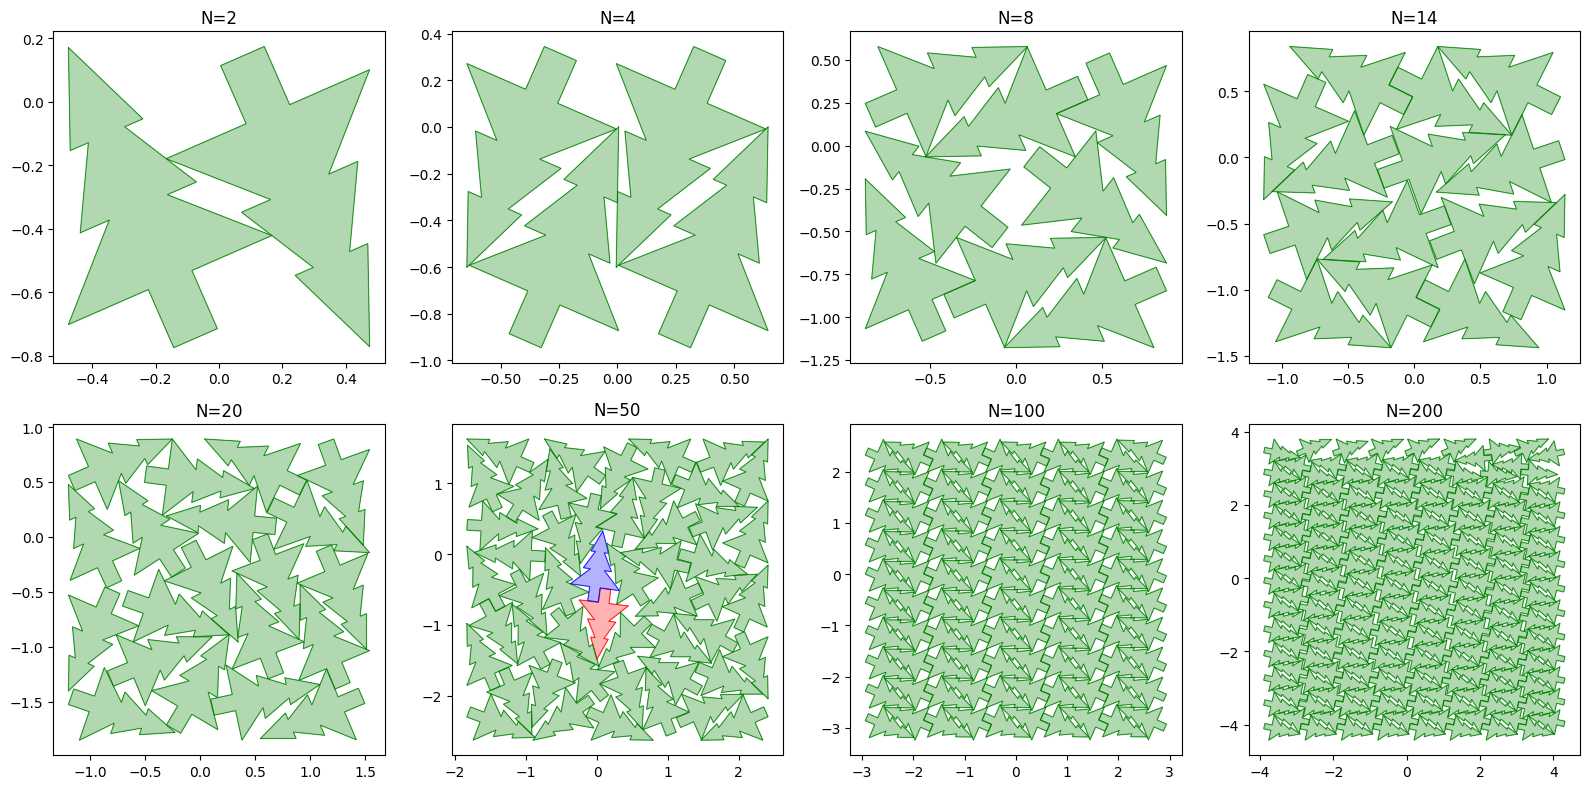

Blue = 0°, Red = 180°, Green = other angles


In [3]:
# Visualize solutions for key N values
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, n in enumerate([2, 4, 8, 14, 20, 50, 100, 200]):
    ax = axes[idx // 4, idx % 4]
    group = df[df['n'] == n]
    
    for _, row in group.iterrows():
        poly = get_tree_polygon(row['x'], row['y'], row['deg'])
        x, y = poly.exterior.xy
        
        # Color by angle: 0° = blue, 180° = red, other = green
        angle = row['deg'] % 360
        if abs(angle) < 10 or abs(angle - 360) < 10:
            color = 'blue'
        elif abs(angle - 180) < 10:
            color = 'red'
        else:
            color = 'green'
        
        ax.fill(x, y, alpha=0.3, color=color)
        ax.plot(x, y, color=color, linewidth=0.5)
    
    ax.set_aspect('equal')
    ax.set_title(f'N={n}')

plt.tight_layout()
plt.savefig('/home/code/exploration/current_solutions_viz.png', dpi=100)
plt.show()
print("Blue = 0°, Red = 180°, Green = other angles")

In [4]:
# Calculate theoretical optimal using double-lattice pattern
# Based on the zaburo kernel approach

def calculate_double_lattice_score(n):
    """Calculate score using alternating up/down pattern."""
    best_score = float('inf')
    
    # Try different row configurations
    for n_even in range(1, n + 1):
        for n_odd in [n_even, n_even - 1, n_even + 1]:
            if n_odd < 0:
                continue
            
            all_trees = []
            rest = n
            r = 0
            
            while rest > 0:
                m = min(rest, n_even if r % 2 == 0 else n_odd)
                if m <= 0:
                    break
                rest -= m
                
                angle = 0 if r % 2 == 0 else 180
                x_offset = 0 if r % 2 == 0 else 0.35  # Half of 0.7
                y = r // 2 * 1.0 if r % 2 == 0 else (0.8 + (r - 1) // 2 * 1.0)
                
                for i in range(m):
                    cx = 0.7 * i + x_offset
                    cy = y
                    all_trees.append(get_tree_polygon(cx, cy, angle))
                
                r += 1
            
            if len(all_trees) == n:
                side = get_bounding_box_side(all_trees)
                score = side ** 2 / n
                if score < best_score:
                    best_score = score
    
    return best_score

# Compare with our current scores
print("Comparing double-lattice pattern with current solutions:")
print("="*60)

for n in [2, 4, 8, 10, 14, 20, 50, 100]:
    group = df[df['n'] == n]
    trees = [get_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    current_side = get_bounding_box_side(trees)
    current_score = current_side ** 2 / n
    
    lattice_score = calculate_double_lattice_score(n)
    
    diff = current_score - lattice_score
    print(f"N={n:3d}: Current={current_score:.6f}, Lattice={lattice_score:.6f}, Diff={diff:+.6f}")

Comparing double-lattice pattern with current solutions:
N=  2: Current=0.450779, Lattice=0.720000, Diff=-0.269221
N=  4: Current=0.416545, Lattice=0.765625, Diff=-0.349080
N=  8: Current=0.385407, Lattice=0.551250, Diff=-0.165843
N= 10: Current=0.376630, Lattice=0.484000, Diff=-0.107370
N= 14: Current=0.370454, Lattice=0.560000, Diff=-0.189546


N= 20: Current=0.376057, Lattice=0.496125, Diff=-0.120068


N= 50: Current=0.360753, Lattice=0.480200, Diff=-0.119447


N=100: Current=0.345531, Lattice=0.396900, Diff=-0.051369


In [5]:
# Calculate total score comparison
print("\nTotal score comparison:")
print("="*60)

current_total = 0
lattice_total = 0

for n in range(1, 201):
    group = df[df['n'] == n]
    if len(group) != n:
        print(f"Warning: N={n} has {len(group)} trees")
        continue
    
    trees = [get_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    current_side = get_bounding_box_side(trees)
    current_score = current_side ** 2 / n
    current_total += current_score
    
    # Only calculate lattice for larger N (small N are already optimal)
    if n >= 10:
        lattice_score = calculate_double_lattice_score(n)
        lattice_total += lattice_score
    else:
        lattice_total += current_score

print(f"Current total: {current_total:.6f}")
print(f"Lattice total: {lattice_total:.6f}")
print(f"Difference: {current_total - lattice_total:+.6f}")
print(f"\nTarget: 68.919154")
print(f"Gap from current: {current_total - 68.919154:.6f}")


Total score comparison:


Current total: 70.659437
Lattice total: 85.957843
Difference: -15.298406

Target: 68.919154
Gap from current: 1.740283


In [6]:
# Analyze which N values have the most room for improvement
print("\nPer-N score analysis (sorted by contribution to total):")
print("="*70)

scores = []
for n in range(1, 201):
    group = df[df['n'] == n]
    if len(group) != n:
        continue
    trees = [get_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    side = get_bounding_box_side(trees)
    score = side ** 2 / n
    scores.append((n, side, score))

# Sort by score contribution
scores.sort(key=lambda x: -x[2])

print(f"{'N':>4} {'Side':>10} {'Score':>10} {'Cumulative':>12}")
print("-" * 40)
cumulative = 0
for n, side, score in scores[:30]:
    cumulative += score
    print(f"{n:4d} {side:10.6f} {score:10.6f} {cumulative:12.6f}")

print(f"\nTop 30 N values contribute {cumulative:.2f} out of {current_total:.2f} ({100*cumulative/current_total:.1f}%)")


Per-N score analysis (sorted by contribution to total):


   N       Side      Score   Cumulative
----------------------------------------
   1   0.813173   0.661250     0.661250
   2   0.949504   0.450779     1.112029
   3   1.142031   0.434745     1.546774
   5   1.443692   0.416850     1.963624
   4   1.290806   0.416545     2.380169
   7   1.673104   0.399897     2.780065
   6   1.548438   0.399610     3.179676
   9   1.867280   0.387415     3.567091
   8   1.755921   0.385407     3.952498
  15   2.384962   0.379203     4.331701
  10   1.940696   0.376630     4.708331
  21   2.811667   0.376451     5.084782
  20   2.742469   0.376057     5.460839
  11   2.033002   0.375736     5.836575
  22   2.873270   0.375258     6.211833
  16   2.446640   0.374128     6.585961
  26   3.118320   0.373997     6.959958
  12   2.114873   0.372724     7.332682
  13   2.199960   0.372294     7.704976
  25   3.050182   0.372144     8.077120
  14   2.277357   0.370454     8.447574
  31   3.388245   0.370329     8.817903
  17   2.508124   0.370040     9.187944

In [7]:
# Check if our solutions for N=2, 4, 8, 14 match known optimal patterns
print("\nVerifying known optimal solutions:")
print("="*60)

# N=1: Single tree at 45 degrees is optimal
n = 1
group = df[df['n'] == n]
angle = group['deg'].values[0] % 360
print(f"N=1: angle={angle:.1f}° (optimal is 45°)")

# N=2: Two trees should be at 0° and 180° (or similar symmetric)
n = 2
group = df[df['n'] == n]
angles = sorted(group['deg'].values % 360)
print(f"N=2: angles={angles} (optimal is symmetric up/down)")

# N=4: Should form a 2x2 grid with alternating orientations
n = 4
group = df[df['n'] == n]
angles = sorted(group['deg'].values % 360)
print(f"N=4: angles={angles}")

# N=8: Should be 4x2 or similar with alternating
n = 8
group = df[df['n'] == n]
angles = sorted(group['deg'].values % 360)
print(f"N=8: angles={angles}")

# N=14: Known optimal
n = 14
group = df[df['n'] == n]
angles = sorted(group['deg'].values % 360)
print(f"N=14: angles={angles[:5]}... (showing first 5)")


Verifying known optimal solutions:
N=1: angle=45.0° (optimal is 45°)
N=2: angles=[23.629377730656792, 203.62937773065684] (optimal is symmetric up/down)
N=4: angles=[156.3706221456364, 156.3706222692641, 336.37062214563645, 336.370622269264]
N=8: angles=[23.629377730658298, 51.766737817651176, 113.62937773063825, 113.62937778579092, 203.62937773065676, 231.76673780277858, 293.62937773063857, 293.62937778579095]
N=14: angles=[63.43109388971889, 63.43109389788883, 63.43278617808365, 108.48137325457422, 109.49644809863294]... (showing first 5)
